# Medical Images Project
---
This proposal 3 objectives:  
1. DICOM loading and visualization
2. 3D Image Segmentation
3. 3D Rigid Coregistration

As we can choose 2 of the 3 objectives, we choose 1 and 2.

## DICOM loading and visualization section

**a) Download the sample RadCTTACEomics DDDD (click here), where DDDD is the sample associated to you (see assignment in Aula Digital).**  

RadCTTACEomics_1447
  
- **Reference image**: 11_AP_Ax5.00mm
- **Input image**: 31_EQP_Ax5.00mm


In [1]:
import os
import pydicom
import highdicom as hd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import matplotlib.animation as animation
import scipy.ndimage
from matplotlib.colors import ListedColormap
import cv2
import SimpleITK as sitk

In [2]:
import numpy as np
from scipy import ndimage as ndi
from skimage.feature import canny
from skimage.filters import gaussian
from skimage.segmentation import watershed, mark_boundaries
from skimage.measure import regionprops, label
from skimage.measure import label, regionprops
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import find_contours

In [3]:
#Constants
path_reference="../1447/11_AP_Ax5.00mm/"
path_input="../1447/31_EQP_Ax5.00mm/"
path_roi_liver="../1447/11_AP_Ax5.00mm_ManualROI_Liver.dcm"
path_roi_tumor="../1447/11_AP_Ax5.00mm_ManualROI_Tumor.dcm"

**b) Visualize it with the help of a third party DICOM visualizer (3D-Slicer is recommended).**   
To help use with the visualization we follow the advices from:
3rd party visualization: https://spujol.github.io/SlicerDICOMTutorial/3DSlicer_DICOMTutorial_SoniaPujol.pdf


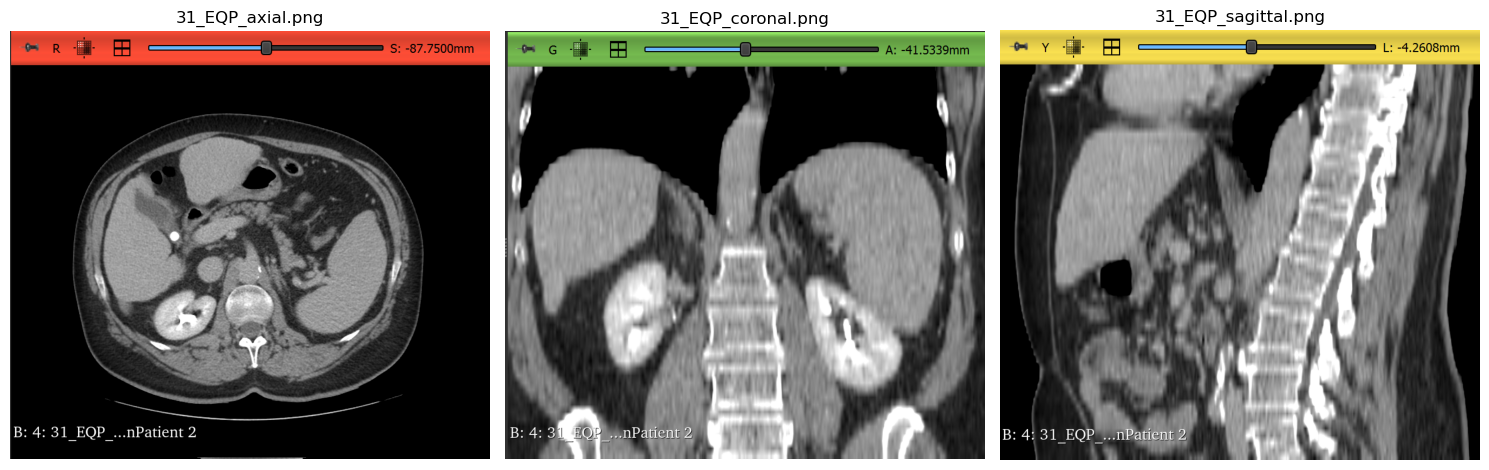

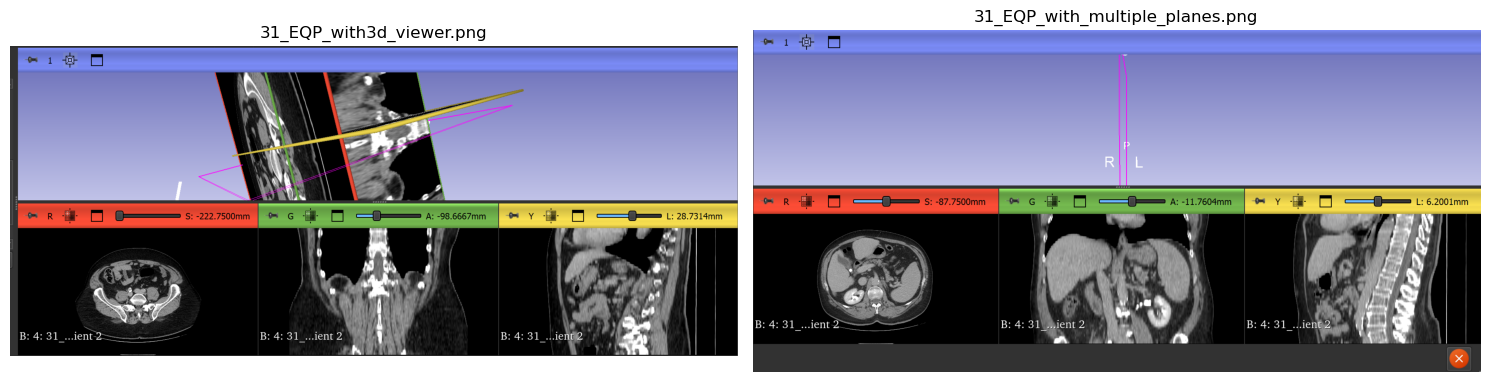

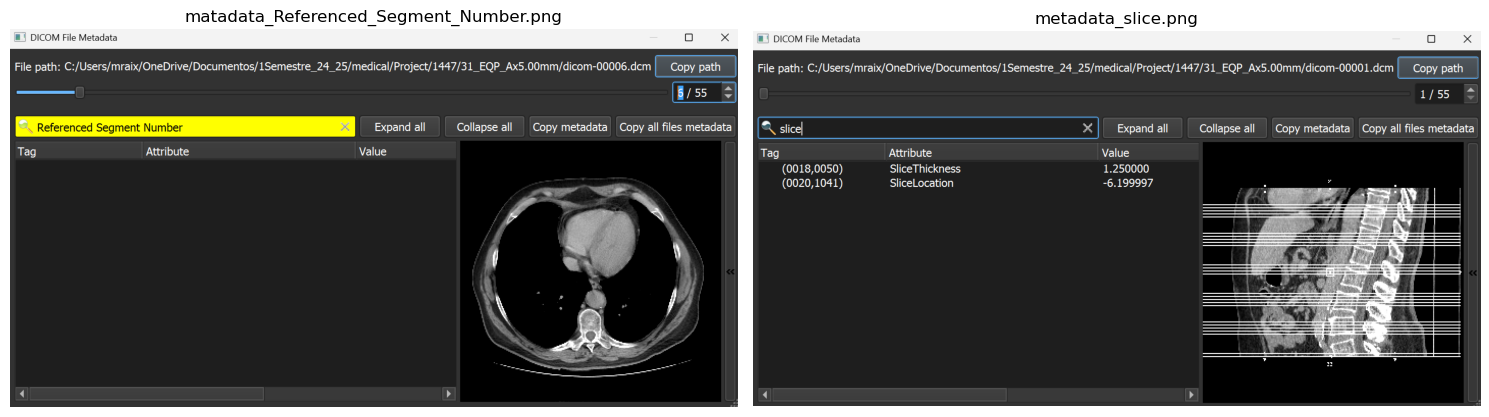

In [4]:
folder_path = "3d_slicer_photos/"
image_paths = list(Path(folder_path).glob('*.png'))  

group_pattern = [3, 2, 2]
groups = []
start_idx = 0

for count in group_pattern:
    end_idx = start_idx + count
    groups.append(image_paths[start_idx:end_idx])
    start_idx = end_idx

for group in groups:
    plt.figure(figsize=(15, 5))
    
    for idx, img_path in enumerate(group, 1):
        img = Image.open(img_path)
        
        plt.subplot(1, len(group), idx)
        plt.imshow(img)
        plt.axis('off')
        plt.title(img_path.name)
    
    plt.tight_layout()
    plt.show()


The visualisation is presented using 3D Slicer software. These images, captured on disparate image planes, function as a reference model during the display and processing of images in Python. A thorough review of the metadata pertaining to the reference image has been conducted for a selection of headers. This investigation was undertaken to ascertain the correlation between the various images, their relationship to one another, and the information that could be obtained. It is also check the data physical dimensions of the image data, it is missing space between slices.

**c) Load the reference CT image (pydicom) and the associated segmentations (highdicom)**  
Rearrange the image and segmentation ‘pixel array’ given by PyDicom based on the headers. Some relevant headers include:  
- ‘Acquisition Number’.
- ‘Slice Index’.
- ‘Per-frame Functional Groups Sequence’ -> ‘Image Position Patient’.
- ‘Segment Identification Sequence’ -> ‘Referenced Segment Number’
---


To order the attributes consistently while considering one axis from the 3D position, follow these steps:

- Acquisition Number: Start by sorting images based on the acquisition number. This ensures that images from different scans (e.g., pre-contrast vs. post-contrast) are grouped separately. A smaller acquisition number indicates an earlier scan, so it should come first.

- Slice Index: Within each acquisition group, sort the images by their slice index. This arranges the slices in the correct sequential order for reconstructing the 3D volume.

- Image Position Patient (Specific Axis): If there is a tie in the slice index, sort the images based on one specific axis from the 3D position (e.g., the z-axis for axial slices). Consistently using one axis ensures proper alignment of slices in 3D space along that dimension.

- Referenced Segment Number: Finally, if all previous attributes are identical, sort by the referenced segment number to distinguish between different anatomical regions or structures within the image.

Headers study: This approach ensures consistency by focusing on a single axis for spatial alignment while maintaining a hierarchical ordering structure.
Headers of the reference image and of the segmented image of the liver have been manually reviewed. In the first of the 4 data requested, only the first 3 can be obtained. And in the case of the segmented image the position of the patient and the Referenced Segment Number.

example=pydicom.dcmread("../1447/11_AP_Ax5.00mm/dicom-00001.dcm")  
example_image = example.pixel_array

In [5]:
def load_dicom_files(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')]
    return [pydicom.dcmread(f) for f in files]

def extract_read_headers(dcm_files):
    headers = []
    for dcm_file in dcm_files:
        acquisition_number = dcm_file.get('AcquisitionNumber', None)
        slice_index = dcm_file.InstanceNumber
        img_position_patient = dcm_file.ImagePositionPatient if 'ImagePositionPatient' in dcm_file else None
        img_orientation_patient=dcm_file.ImageOrientationPatient
        slice_location=dcm_file.SliceLocation
        headers.append({
            'file': dcm_file,
            'acquisition_number': acquisition_number,
            'slice_index': slice_index,
            'image_position_patient': img_position_patient,
            'img_orientation_patient':img_orientation_patient,
            'slice_location':slice_location
        })
    return headers
    
def check_is_single_adquisition(headers):
    unique_acquisition_numbers = set()
    for header in headers:
        unique_acquisition_numbers.add(header['acquisition_number'])
    if len(unique_acquisition_numbers)==1:   
        print(f"The slices of the CT image contain only a single acquisition")
    else:
        print(f"The slices of the CT image contain more than one acquisition")
        
def rearrange_img_segmentation_by_headers(headers):
    # Sort headers based on the relevant attributes
    sorted_headers = sorted(headers, key=lambda x: (
        x['acquisition_number'] if x['acquisition_number'] is not None else 0,
        x['slice_index'] if x['slice_index'] is not None else 0,
        x['image_position_patient'][2] if x['image_position_patient'] is not None else 0,  # Sort by Z-axis
    ))

    return sorted_headers
def extract_pixel_arrays(sorted_headers):
    return np.stack([header['file'].pixel_array for header in sorted_headers])

def visualize_sorted_slices(sorted_headers, num_slices=5):
    fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))
    for i in range(num_slices):
        axes[i].imshow(sorted_headers[i]['file'].pixel_array, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Slice {i+1}")
    plt.show()
    
def save_sorted_images(sorted_headers, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for i, header in enumerate(sorted_headers):
        output_path = os.path.join(output_folder, f"sorted_image_{i}.dcm")
        header['file'].save_as(output_path)

def show_ordered_headers(sorted_headers):
    for i, header in enumerate(sorted_headers):
        print(f"Header {i+1}:")
        print(f"  Acquisition Number: {header['acquisition_number']}")
        print(f"  Slice Index: {header['slice_index']}")
        print(f"  Image Position Patient: {header['image_position_patient']}")
        print(f"  Image Orientation Patient: {header['img_orientation_patient']}")
        print(f"  Slice location: {header['slice_location']}")
    print(f"  Array Shape from reference image: {pixel_arrays.shape}")


In [6]:
dcm_files = load_dicom_files(path_reference)
headers = extract_read_headers(dcm_files)
check_is_single_adquisition(headers)
sorted_headers = rearrange_img_segmentation_by_headers(headers)
pixel_arrays = extract_pixel_arrays(sorted_headers)
show_ordered_headers(sorted_headers)

The slices of the CT image contain only a single acquisition
Header 1:
  Acquisition Number: 1
  Slice Index: 1
  Image Position Patient: [5.797, -187.399, 115.75]
  Image Orientation Patient: [0.000000, 1.000000, 0.000000, 0.000000, 0.000000, -1.000000]
  Slice location: -5.797653
Header 2:
  Acquisition Number: 1
  Slice Index: 2
  Image Position Patient: [-200.202, -194.642, 42.562]
  Image Orientation Patient: [1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]
  Slice location: 42.562500
Header 3:
  Acquisition Number: 1
  Slice Index: 3
  Image Position Patient: [-200.202, -194.642, 37.562]
  Image Orientation Patient: [1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]
  Slice location: 37.562500
Header 4:
  Acquisition Number: 1
  Slice Index: 4
  Image Position Patient: [-200.202, -194.642, 32.562]
  Image Orientation Patient: [1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]
  Slice location: 32.562500
Header 5:
  Acquisition Number: 1
  Slice Ind

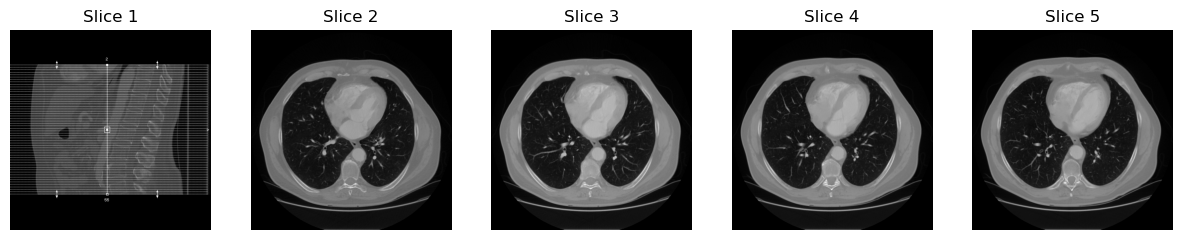

In [7]:
visualize_sorted_slices(sorted_headers)

As you can see we have 55 slices of the reference image, and its height and width is 512x512. We can also see how the first slice is the most different from the others in both orientation, patient position, and plane. 

---
Interesting data for next objectives.  
  
Oriantation:  
- The first three numbers are the direction of the image rows.
- The next three numbers are the direction of the image columns.
- Both are given in the patient coordinate system: X (Right-Left), Y (Anterior-Posterior), Z (Inferior-Superior)

[0.000000, 1.000000, 0.000000, 0.000000, 0.000000, -1.000000]  
- Row direction: (0, 1, 0) → Along the Y axis (Anterior to Posterior)
- Column direction: (0, 0, -1) → Along the negative Z axis (Superior to Inferior)
- The image rows go from anterior to posterior.
- The image columns go from superior to inferior.
- The image plane is perpendicular to the X axis (Right-Left).
- This is a sagittal plane.

[1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]
- Row direction: (1, 0, 0) → Along the x axis left to right
- Column direction: (0, 1, 0) → Along the Y axis (Anterior to Posterior)
- The image rows go from right to left.
- The image columns go from anterior to posterior.
- The image plane is perpendicular to the Z axis (Inferior-Superior).
  
This is an axial plane (top-down slices)
If there was a coronal, will have same row direction as in the axial, however the column direction: (0, 0, 1) - inferior to superior (patient’s Z axis)  

---
In order to perform image enhancement, window center and windown width must be obtained. As the first image has artifacts fromt he machine, it is need to remove those artifacts, prior we will do a windowing, and then apply the FFT basd removal, then the dynamic range (min/max values) of the image can change, often reducing the contrast between the torso and background. Better in this order in the other way around the FFT may introduce negative values or flatten intensity differences, and applying the windowing after the image will be not showing correctly the image.

In [8]:
def get_windowing(dcm):
    try:
        window_center = float(dcm.WindowCenter)
        window_width = float(dcm.WindowWidth)
        print(f"window_center: {window_center}", f"window_width: {window_width}")
        return window_center, window_width
    except AttributeError:
        # Estimate windowing if not present WindowCenter, and WindowWidth
        pixels = dcm.pixel_array
        max_value = np.max(pixels)
        min_value = np.min(pixels)
        window_center = (max_value + min_value) / 2
        window_width = max_value - min_value
        return window_center, window_width

def apply_windowing(pixel_array, window_center, window_width):
    lower_bound = window_center - window_width / 2
    upper_bound = window_center + window_width / 2
    windowed_array = np.clip(pixel_array, lower_bound, upper_bound)
    return windowed_array

In [9]:
window_center, window_width = get_windowing(dcm_files[1])
windowed_ct_images = np.array([apply_windowing(img, window_center, window_width) for img  in pixel_arrays])
#New values lower_bound: 200.0, upper_bound: 600.0

window_center: 40.0 window_width: 400.0


In [10]:
def normalize_img(img):
    # Normalize to [0, 1]
    img = img.astype(np.float32)
    return (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)

def denormalize_img(img_norm, original_min, original_max):
    # Map normalized [0,1] image back to original range
    return img_norm * (original_max - original_min) + original_min

def apply_fft(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    return 20 * np.log(np.abs(fshift) + 1), fshift

def create_mask(img, band_size=5, center_size=15):
    rows, cols = img.shape
    crow, ccol = rows // 2 , cols // 2
    mask = np.ones((rows, cols), np.float32)
    # Block grid frequency lines (horizontal and vertical)
    mask[crow-band_size:crow+band_size, :] = 0
    mask[:, ccol-band_size:ccol+band_size] = 0
    # Allow a center area (low frequencies)
    mask[crow-center_size:crow+center_size, ccol-center_size:ccol+center_size] = 1
    # Optional: smooth with gaussian
    # from scipy.ndimage import gaussian_filter
    # mask = gaussian_filter(mask, sigma=3)
    return mask

def apply_mask_inv_fft(fshift, mask):
    fshift_filtered = fshift * mask
    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.real(img_back)  # Use real part, as input is real
    return img_back

def extract_machine_grid(img, show=False):
    # 1. Save original min/max for later
    orig_min, orig_max = np.min(img), np.max(img)
    img_norm = normalize_img(img)
    # 2. FFT
    magnitude_spectrum, fshift = apply_fft(img_norm)
    # 3. Show spectrum
    if show:
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1), plt.imshow(img, cmap='gray'), plt.title('Original Image')
        plt.subplot(1,2,2), plt.imshow(magnitude_spectrum, cmap='gray'), plt.title('FFT Spectrum')
        plt.show()
    # 4. Mask and inverse FFT
    mask = create_mask(img)
    img_back = apply_mask_inv_fft(fshift, mask)
    # 5. Re-normalize to [0, 1]
    img_back_norm = normalize_img(img_back)
    # 6. Scale back to original range (or HU)
    img_back_scaled = denormalize_img(img_back_norm, orig_min, orig_max)
    if show:
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1), plt.imshow(img, cmap='gray'), plt.title('Original')
        plt.subplot(1,2,2), plt.imshow(img_back_scaled, cmap='gray'), plt.title('Grid Removed')
        plt.show()
    return magnitude_spectrum, mask, img_back_scaled, fshift

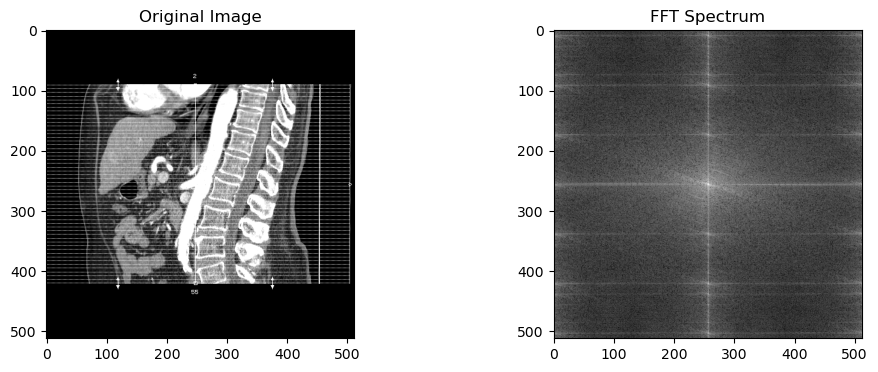

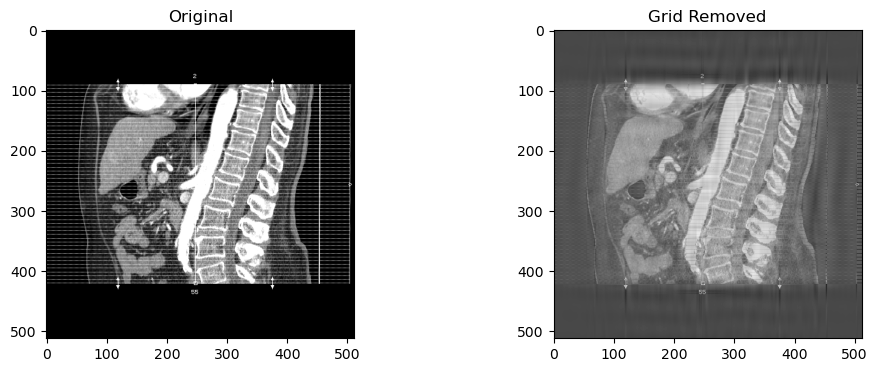

In [11]:
img = windowed_ct_images[0].astype(float)
magnitude_spectrum,mask,img_back,fshift=extract_machine_grid(img,show=True)
windowed_ct_images[0]=img_back

with fft the image withut lines, it seems iap, resaltan menos las partes del cuerpo.

**Segmented images section**

---
Liver and tumor ROI  reading the headers obtaing Z position from the patient and Referenced Segment Number. It will first be used to order by the patient's z-position, then by the Referenced Segment Number. This is Z position, descending as in the reference image.

In [12]:
def read_order_seg_header(seg_file):
    seg_data = []
    shared = seg_file.SharedFunctionalGroupsSequence[0]
    img_orientation_patient = shared.PlaneOrientationSequence[0].ImageOrientationPatient
    slice_thickness = shared.PixelMeasuresSequence[0].SliceThickness
    pixel_spacing = shared.PixelMeasuresSequence[0].PixelSpacing
    for idx, frame in enumerate(seg_file.PerFrameFunctionalGroupsSequence):
        #position = float(frame.PlanePositionSequence[0].ImagePositionPatient[2])
        img_position_patient = frame.PlanePositionSequence[0].ImagePositionPatient
        referenced_segment_number = frame.SegmentIdentificationSequence[0].ReferencedSegmentNumber
        
        seg_data.append({
            'file': idx,
            'image_position_patient': img_position_patient,
            'referenced_segment_number': referenced_segment_number
        })
        seg_data=rearrange_img_segmentation_by_headers(seg_data)
    return seg_data
    
def rearrange_img_segmentation_by_headers(headers):
    sorted_headers = sorted(headers, key=lambda x: (
    -x['image_position_patient'][2] if x['image_position_patient'] is not None else 0,
    x['referenced_segment_number'] if x['referenced_segment_number'] is not None else 0))

    return sorted_headers
    
def order_pixel_data(seg_data, pixel_data):
    sorted_indices = [item['file'] for item in seg_data]
    sorted_pixel_data = pixel_data[sorted_indices, :, :]
    return sorted_pixel_data

def visualize_sorted_slices(sorted_pixel_arrays, num_slices=5):
    fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))
    for i in range(num_slices):
        axes[i].imshow(sorted_pixel_arrays[i], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Slice {i+1}")
    plt.show()

def show_seg_header(sorted_headers):
    for i,item in enumerate(sorted_headers):
        print(f"Header {i+1}:")
        print(f"   Position Patient: {item['image_position_patient']}")
        print(f"  Referenced Segment Number: {item['referenced_segment_number']}")

In [13]:
liver_segmentation = pydicom.dcmread(path_roi_liver)
liver_image = liver_segmentation.pixel_array

In [14]:
seg_data=read_order_seg_header(liver_segmentation)
#show_seg_header(seg_data)
sorted_pixel_data=order_pixel_data(seg_data,liver_image)
print(f"Array Shape from liver segmentation image: {liver_image.shape}")

Array Shape from liver segmentation image: (30, 512, 512)


In [15]:
tumor_segmentation = pydicom.dcmread(path_roi_tumor)
tumor_image = tumor_segmentation.pixel_array

In [16]:
seg_tumor_data=read_order_seg_header(tumor_segmentation)
#show_seg_header(seg_tumor_data)
sorted_tumor_pixel_data=order_pixel_data(seg_tumor_data,tumor_image)
#print(f"Array Shape from tumor segmentation image: {tumor_image.shape}")

Referenced Segment Number, is from the segmentation data, then we have to use path_roi_tumor and path_roi_liver.  
As we can see in both segmented images we do not have the same number of pixel arrays, in the reference image there are about 55, and in the liver segmentation there are 40, and in the tumor one there are 13, so it is not possible to make a simple reslice. As reference data we have the position of the patient, but in the reference image there are about 55 different Z positions, so they will not all coincide. 

---
Reslice the the liver and tumor file to fit to the reference image. It is imperative to consider the patient's position, in conjunction with the prior analysis of the headers. This is due to the fact that, despite the reduced number of slices in the ROI relative to the CT image, patient position variations are confined to the Z axis in both cases.

In [17]:
def extract_ordered_dcm_files(sorted_headers):
    return [header['file'] for header in sorted_headers]
def reorder_roi_match_file(sorted_headers,pixel_array,resliced_roi, dcm_seg):
    # Obtinning the slices, height and width from the reference pixel array
    shape = pixel_array.shape
    
    dcm_files=extract_ordered_dcm_files(sorted_headers)
    # Obtaining Z position from the patient
    ref_positions = [float(dcm.ImagePositionPatient[2]) for dcm in dcm_files]
    ref_pos_to_index = {z: idx for idx, z in enumerate(ref_positions)}
    # Initialization of the mask
    seg_mask = np.zeros(shape, dtype=dcm_seg.pixel_array.dtype)
    for frame_idx, frame in enumerate(dcm_seg.PerFrameFunctionalGroupsSequence):
        # Obtaining Z position from the patient from the mask
        mask_z = float(frame.PlanePositionSequence[0].ImagePositionPatient[2])
        # Find the corresponding table of contents in the original volume
        if mask_z in ref_pos_to_index:
            vol_idx = ref_pos_to_index[mask_z]
            # Insert the mask slice in the correct position.
            seg_mask[vol_idx] = resliced_roi[frame_idx]
        else:
            print(f"Warning: No match found for Z position={mask_z}")
    return seg_mask

In [18]:
liver_mask=reorder_roi_match_file(sorted_headers,pixel_arrays,liver_image,liver_segmentation)
print(f"Array Shape from liver resliced: {liver_mask.shape}")

Array Shape from liver resliced: (55, 512, 512)


In [19]:
tumor_mask=reorder_roi_match_file(sorted_headers,pixel_arrays,tumor_image,tumor_segmentation)
print(f"Array Shape from liver resliced: {tumor_mask.shape}")

Array Shape from liver resliced: (55, 512, 512)


Check if the reslice is correct, we use the 20th image where both ROIs are clearly shown. Both masks have the same shape as the reference image.

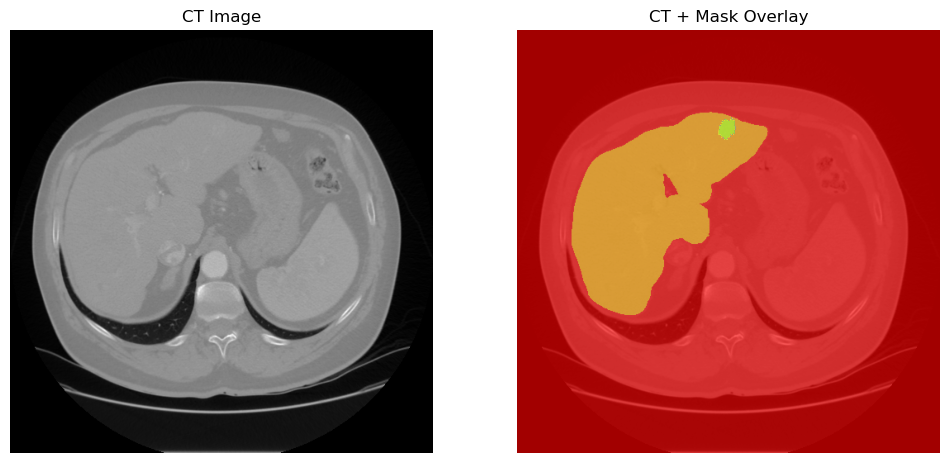

In [20]:
slice_idx =20
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("CT Image")
plt.imshow(pixel_arrays[slice_idx], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("CT + Mask Overlay")
plt.imshow(pixel_arrays[slice_idx], cmap='gray')
plt.imshow(tumor_mask[slice_idx], cmap='prism', alpha=0.4)  
plt.imshow(liver_mask[slice_idx], cmap='autumn', alpha=0.4)  # Mask in color, semi-transparent
plt.axis('off')
plt.show()


**d) Create an animation (e.g. gif file) with a rotating Maximum Intensity Projection on the
coronal-sagittal planes, visualizing the tumoral mask.**




Since the headers do not contain the space between slices information, we must calculate this data. Then each CT slice includes an "Image Position (Patient)" field, which gives the 3D coordinates (in mm) of the upper-left voxel of the image in the patient coordinate system. Obtaining the difference between the different two adjacent slices, this difference is calculate euclidean distance.

Axial aspect ration 1.0
Sagittal aspect ration 6.213588372139264
Coronal aspect ration 6.213588372139264


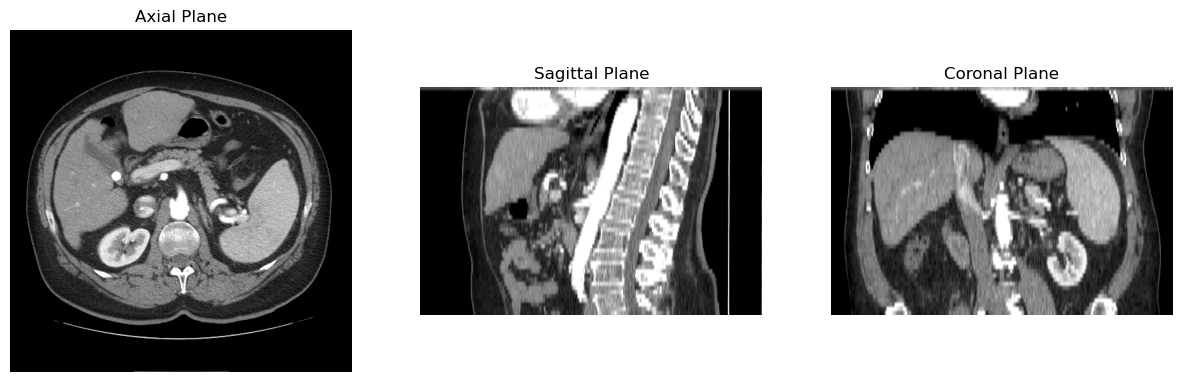

In [21]:
def get_image_position(ds):
    # Returns the Image Position (Patient) as a numpy array
    return np.array(ds.ImagePositionPatient, dtype=float)
   
def obtain_space_data(images):
    sample_img=images[0]
    
    pixel_spacing = sample_img.PixelSpacing  #is an array for the x and y 
    # Get positions for all slices
    space_between_slices=None
    positions = [get_image_position(ds) for ds in images]

    if len(positions) >= 2:
        #Do not use first image most of the image are axial planes execpt for the 1st
        space_between_slices = np.linalg.norm(positions[2] - positions[1])
   
    slice_thickness = sample_img.SliceThickness
    return pixel_spacing, space_between_slices, slice_thickness
 
def obtain_aspects_planes(images):
    pixel_spacing, space_between_slices, slice_thickness=obtain_space_data(images)

    axial_aspect_ratio = pixel_spacing[1] / pixel_spacing[0]
    sagittal_aspect_ratio = space_between_slices/pixel_spacing[0]
    coronal_aspect_ratio =  space_between_slices /pixel_spacing[1]
    print(f'Axial aspect ration {axial_aspect_ratio}')
    print(f'Sagittal aspect ration {sagittal_aspect_ratio}')
    print(f'Coronal aspect ration {coronal_aspect_ratio}')
    return axial_aspect_ratio,sagittal_aspect_ratio, coronal_aspect_ratio
def obtain_pixel_mm(images):
    ## pixel_len_mm = [slice_thickness, row_spacing, col_spacing]
    pixel_spacing, space_between_slices, slice_thickness=obtain_space_data(images)
    return [pixel_spacing[0],pixel_spacing[1],slice_thickness]
    
def visualize_planes(ct_volume,axial_aspect_ratio, aspect_ratio_sagittal, aspect_ratio_coronal):
   
    # Obtaining planes
    coronal_plane =ct_volume[:, ct_volume.shape[2] // 2, :] 
    sagittal_plane = ct_volume[:, :, ct_volume.shape[1] // 2]
    axial_plane = ct_volume[ct_volume.shape[0] // 2, :, :]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    # Visualize planes with aspect
    axes[0].imshow(axial_plane, cmap='gray', aspect=axial_aspect_ratio)
    axes[0].set_title('Axial Plane')
    axes[0].axis('off')
    
    axes[1].imshow(sagittal_plane, cmap='gray', aspect=aspect_ratio_sagittal)
    axes[1].set_title('Sagittal Plane')
    axes[1].axis('off')
    
    axes[2].imshow(coronal_plane, cmap='gray', aspect=aspect_ratio_coronal)
    axes[2].set_title('Coronal Plane')
    axes[2].axis('off')

    plt.show()
    
axial_aspect_ratio,aspect_ratio_sagittal, aspect_ratio_coronal=obtain_aspects_planes(dcm_files)
pixel_mm=obtain_pixel_mm(dcm_files)
visualize_planes(windowed_ct_images,axial_aspect_ratio, aspect_ratio_sagittal, aspect_ratio_coronal)

**Estic apicar s'alpha epr tot nomes a ha ser on hi la mascara y no el fons de la mascara, per axó s'enfosqueix el fons general.**
asumsió de forma de tumors, es arrodonida, no infiltracions.

In [29]:

'''
#FFD700 (Amarillo dorado)
#FF00FF (Magenta)
#00FFFF (Cian)
#000000 (Negro)

'''

def normalize_foreground(fg):
    # Add 1e-8 to avoid division by 0
    return (fg.astype(float) - fg.min()) / (fg.max() - fg.min() + 1e-8)

def overlay_fg(alpha_ly, fg, canvas, fg_color):
    # Create a mask where the foreground is not zero
    mask = fg != 0
    # Initialize alpha with zeros
    alpha = np.zeros_like(fg, dtype=float)[..., None]  # shape (H, W, 1)
    # Set alpha to alpha_ly where the mask is True
    alpha[mask] = alpha_ly
    # Blend foreground onto result wherever mask is True, with some transparency
    result = canvas.copy()
    result[mask] = canvas[mask] * (1 - alpha_ly) + fg_color[mask] * alpha_ly
    result[mask==0] = canvas[mask==0] * 1
    return result

# Method to apply alpha fusion and painter's algorithm over a loop for all images,
# and then stack them, so it can be used for projections
def alpha_fusion_painter_alg(ct_imgs, mask1, mask2, alpha_ly):
    canvas_result = []
    # Assume all have the same quantity,
    # as the masks have been created

    my_colors = ['#FF0000']  # Red
    my_cmap = ListedColormap(my_colors)
    my_colors = ['#00FFFF']  #
    my_cmap2 = ListedColormap(my_colors)
    for i in range(ct_imgs.shape[0]):
        bg = ct_imgs[i]
        fg1 = mask1[i]
        fg2 = mask2[i]

        # Normalize
        fg1_norm = normalize_foreground(fg1)
        fg2_norm = normalize_foreground(fg2)
        # Convert to RGBA
        fg1_color = my_cmap(fg1_norm)[..., :3]
        fg2_color = my_cmap2(fg2_norm)[..., :3]

        bg_rgb = np.stack([bg]*3, axis=-1) / 255.0
        canvas = bg_rgb.copy()

        canvas = overlay_fg(alpha_ly[0], fg1, canvas, fg1_color)
        canvas = overlay_fg(alpha_ly[1], fg2, canvas, fg2_color)

        # Normalize result to have a valid range
        canvas_result.append(np.clip(canvas, 0, 1))
    return canvas_result

alpha_ly = [0.3, 0.5]
canvas_result = alpha_fusion_painter_alg(windowed_ct_images, liver_mask, tumor_mask, alpha_ly)
alpha_fusioned = np.stack([part for part in canvas_result])


(-0.5, 511.5, 511.5, -0.5)

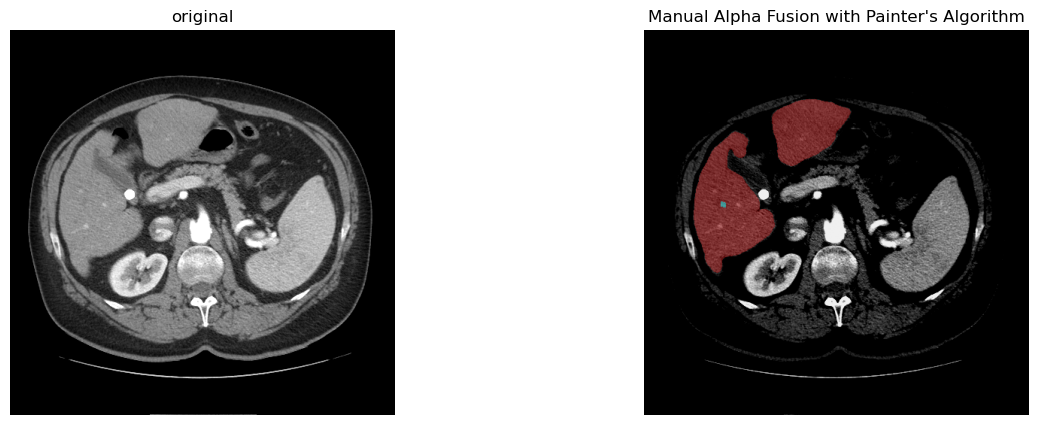

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(windowed_ct_images[27], cmap='gray')
axes[0].set_title('original')
axes[0].axis('off')
axes[1].imshow(alpha_fusioned[27])
axes[1].set_title("Manual Alpha Fusion with Painter's Algorithm")
axes[1].axis('off')

In [82]:
def create_mip(volume, axis):
    """Crea una proyección de máxima intensidad (MIP) a lo largo de un eje."""
    return np.max(volume, axis=axis)

def obtain_mip_planes(volume):
    """Obtiene las proyecciones MIP en los tres planos principales."""
    return (
        create_mip(volume, axis=0),  # Axial
        create_mip(volume, axis=1),  # Coronal
        create_mip(volume, axis=2)   # Sagital
    )

def rotate_on_axial_plane(volume, angle):
    """Rota el volumen alrededor del plano axial (eje z)."""
    return scipy.ndimage.rotate(volume, angle, axes=(1, 2), reshape=False, order=1)

def plot_3d_combined(ct_image, aspect_ratio_coronal, n=30, output_path='animation_gif'):
    """Genera proyecciones MIP rotadas y crea una animación GIF."""
    os.makedirs(output_path, exist_ok=True)
    angles = np.linspace(0, 360, num=n, endpoint=False)
    projections = []

    # Genera y guarda las proyecciones MIP rotadas
    for idx, angle in enumerate(angles):
        rotated = rotate_on_axial_plane(ct_image, angle)
        mip_coronal = create_mip(rotated, axis=1)
        mip_coronal_clipped = np.clip(mip_coronal, 0, 1)
        projections.append(mip_coronal_clipped)

        plt.figure(figsize=(8, 8))
        plt.imshow(mip_coronal_clipped, cmap='gray', aspect=aspect_ratio_coronal, alpha=0.6, origin='lower')
        plt.title(f'Proyección {idx}')
        plt.axis('off')
        plt.savefig(os.path.join(output_path, f'Projection_{idx}.png'), bbox_inches='tight', pad_inches=0)
        plt.close()

    # Crea la animación GIF
    fig, ax = plt.subplots()
    ani_frames = [
        [ax.imshow(proj, cmap='gray', aspect=aspect_ratio_coronal, animated=True, alpha=0.6, origin='lower')]
        for proj in projections
    ]
    anim = animation.ArtistAnimation(fig, ani_frames, interval=100, blit=True)
    gif_path = os.path.join(output_path, 'Animation.gif')
    anim.save(gif_path, writer='pillow')
    plt.close(fig)

    print(f"Path: '{gif_path}'")
    return gif_path

gif_path = plot_3d_combined(alpha_fusioned, aspect_ratio_coronal)

Path: 'animation_gif\Animation.gif'


**Consider the Tumor mask associated to the reference image, and extract its bounding box and centroid.**  

---
centro geométrico de la forma de la máscara, similar a cómo se define el centroide de otras figuras geométricas. El centroide es el punto donde se intersecan las medianas de la figura. Si tienes una serie de imágenes (slices) de un volumen DICOM, debes calcular el centroide en cada slice por separado si quieres conocer el centroide de la región segmentada en cada plano. Se ha revisado y el tumor solo parece tener una región.

In [24]:
#obtener los slices que tiene valor, ya que el original el tumor solo tenia 13. desde el resliced
def obtain_slice_mask(tumor_mask):
    slices_data=[]
    for i in range(tumor_mask.shape[0]):
        if np.any(tumor_mask[i] == 1):
            centroid=obtain_centroid(tumor_mask[i])
            bounding_box=obtain_bounding_box(tumor_mask[i])
            slices_data.append({
                'num_slice': i,
                'slice': tumor_mask[i],
                'centroid': centroid,
                'bounding_box': bounding_box
            })
    return slices_data
#extraer el centroide
def obtain_centroid(tumor_mask_slice):
    idcs = np.argwhere(tumor_mask_slice >0)
    centroid = np.mean(idcs, axis=0) 
    y, x = centroid  
    return ( y, x)
def obtain_bounding_box(tumor_mask_slice):
    #indices = np.argwhere(tumor_mask_slice > 0)
    rows = np.any(tumor_mask_slice > 0, axis=1)
    cols = np.any(tumor_mask_slice > 0, axis=0)

    # Índices de los límites
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]
    return ((ymin, xmin), (ymax, xmax))
def show_results(result):
    for i, data in enumerate(result):
        print(f"Slice {data['num_slice']}:")
        print(f"  Centroid x {data['centroid'][1]}, y {data['centroid'][0]}")
        print(f"  Bounding box: xmin {data['bounding_box'][0][1]}, ymin {data['bounding_box'][0][0]}, xmax {data['bounding_box'][1][1]} , ymax {data['bounding_box'][1][0]}")
    print(f"Amount of slices with mask: {len(result)}")

In [25]:
tumor_mask[20].ndim == 2
result=obtain_slice_mask(tumor_mask)

In [26]:
show_results(result)

Slice 11:
  Centroid x 154.28947368421052, y 210.52631578947367
  Bounding box: xmin 151, ymin 208, xmax 157 , ymax 213
Slice 12:
  Centroid x 151.19011406844106, y 211.94296577946767
  Bounding box: xmin 142, ymin 204, xmax 160 , ymax 220
Slice 13:
  Centroid x 151.9602122015915, y 211.81962864721484
  Bounding box: xmin 140, ymin 203, xmax 164 , ymax 221
Slice 14:
  Centroid x 153.54117647058823, y 211.12941176470588
  Bounding box: xmin 146, ymin 205, xmax 161 , ymax 217
Slice 18:
  Centroid x 254.66666666666666, y 120.82222222222222
  Bounding box: xmin 251, ymin 118, xmax 258 , ymax 124
Slice 19:
  Centroid x 253.855, y 120.605
  Bounding box: xmin 244, ymin 113, xmax 262 , ymax 127
Slice 20:
  Centroid x 253.73901098901098, y 118.92032967032966
  Bounding box: xmin 244, ymin 106, xmax 263 , ymax 132
Slice 21:
  Centroid x 253.18157894736842, y 120.97368421052632
  Bounding box: xmin 243, ymin 110, xmax 264 , ymax 132
Slice 22:
  Centroid x 250.87562189054725, y 122.33333333333333

Centroid and bounding box from the overall mask

In [27]:
#General
coords = np.argwhere(tumor_mask > 0)  # Returns (N, 2) array of (y, x)
y_coords, x_coords = coords[:, 0], coords[:, 1]
y_min, y_max = np.min(y_coords), np.max(y_coords)
x_min, x_max = np.min(x_coords), np.max(x_coords)
print(f"Overall Bounding box: xmin {x_min}, ymin {y_min}, xmax {x_max} , ymax {y_max}")

Overall Bounding box: xmin 106, ymin 11, xmax 236 , ymax 27


In [28]:
y, x = np.where(mask == 1)  
centroid = (np.mean(y), np.mean(x))
centroid
print(f"Centroid x {centroid[1]}, y {centroid[0]}")

Centroid x 255.5, y 255.5


**Create a semi-automatic tumor segmentation algorithm that only uses the CT image, and
either the bounding box or the centroid of the tumor.**

Se usaria los datos de higado para imitar la zona donde buscar, y poder usar metoso tipo watershed o similar para poder obtener donde esta el mascara del tumor. Liver 20-60 este rango similar al de la sangre, https://radiopaedia.org/articles/hounsfield-unit -> liver: 45-50 HU. Mejor no realizar umbralización directamente, quitar artefactos, y además ver bordes, y revisar que tendencia de forma tiene el higado connected components, y obtener el roi, y después de eso connectec components/watershed. El hígado es el órgano sólido más grande del cuerpo humano y se encuentra en el cuadrante superior derecho del abdomen, debajo del diafragma.

https://www.reddit.com/r/learnpython/comments/pygwnu/how_to_define_the_markers_in_the_watershed/?tl=es-es&rdt=32963

---
- Axial: Forma de cuña o semilunar, con el borde anterior afilado y el posterior más redondeado. Ocupa el cuadrante superior derecho, por debajo del diafragma y por encima del riñón derecho y la vesícula biliar. Suele ser el componente más grande y homogéneo en densidad en el abdomen superior.
- Coronal: Apariencia triangular o trapezoidal, con el vértice hacia el lado izquierdo. El borde superior sigue el contorno del diafragma y el inferior es más irregular, adaptándose a las vísceras abdominales. El lóbulo derecho es más grande y el izquierdo se extiende hacia la línea media.
- Sagital: Perfil convexo superior (bajo el diafragma) y cóncavo inferior (por la impresión del colon y otras vísceras). Puede verse una masa homogénea grande en la parte anterior del abdomen, por encima del riñón derecho.

Buscar el componente más grande y homogéneo en la región superior derecha del abdomen.

Analizar la relación anatómica con estructuras vecinas: el hígado contacta con el diafragma por arriba, el riñón derecho y la vesícula biliar por detrás y medialmente, y el estómago y colon por debajo.

Considerar la continuidad en cortes sucesivos: el hígado se extiende en varios cortes y su contorno es relativamente regular, salvo en casos de patología.

Usar segmentación basada en forma y posición: algoritmos de análisis de componentes conectados pueden identificar el mayor componente conectado en la zona anatómica esperada; la validación por forma y localización ayuda a evitar confusiones con otros órganos grandes.

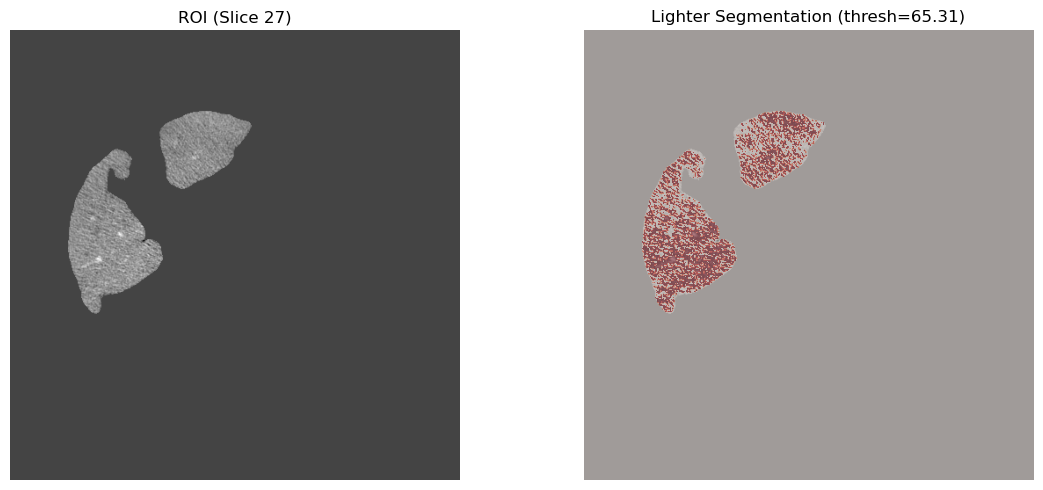

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.filters import threshold_otsu

def segment_lighter(region, method='manual', manual_thresh=0.5):

    masked = region[region > 0]  # Only inside the ROI
    if method == 'otsu' and masked.size > 0:
        thresh = threshold_otsu(masked)
    else:
        thresh = manual_thresh

    # Select voxels above threshold (lighter)
    seg_mask = (region > 0) & (region >= thresh)
    return seg_mask.astype(np.uint8), thresh

def show_segmentation(region, seg_mask, thresh, slice_idx=None):
    if slice_idx is None:
        slice_idx = region.shape[0] // 2
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(region[slice_idx], cmap='gray')
    plt.title("ROI (Slice {})".format(slice_idx))
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(region[slice_idx], cmap='gray')
    plt.imshow(seg_mask[slice_idx], alpha=0.5, cmap='Reds')
    plt.title(f"Lighter Segmentation (thresh={thresh:.2f})")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

region = windowed_ct_images * liver_mask
seg_mask, thresh = segment_lighter(region, method='otsu')
show_segmentation(region, seg_mask, thresh)

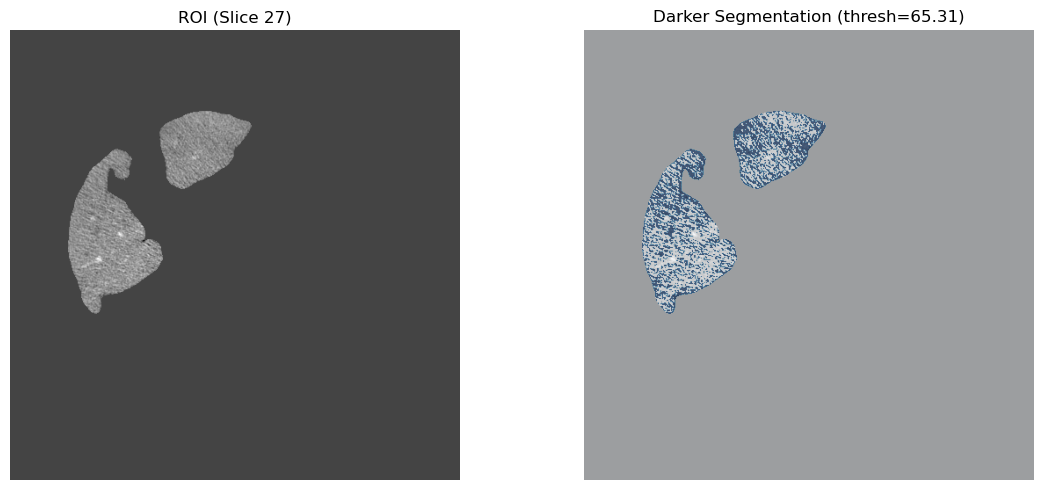

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.filters import threshold_otsu

def segment_darker(region, method='manual', manual_thresh=0.5):
    masked = region[region > 0]  # Only inside the ROI
    if method == 'otsu' and masked.size > 0:
        thresh = threshold_otsu(masked)
    else:
        thresh = manual_thresh

    # Select voxels below threshold (darker)
    seg_mask = (region > 0) & (region <= thresh)
    return seg_mask.astype(np.uint8), thresh



def show_segmentation(region, seg_mask, thresh, slice_idx=None):
    if slice_idx is None:
        slice_idx = region.shape[0] // 2
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(region[slice_idx], cmap='gray')
    plt.title("ROI (Slice {})".format(slice_idx))
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(region[slice_idx], cmap='gray')
    plt.imshow(seg_mask[slice_idx], alpha=0.5, cmap='Blues')
    plt.title(f"Darker Segmentation (thresh={thresh:.2f})")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


region = windowed_ct_images * liver_mask
seg_mask, thresh = segment_darker(region, method='otsu')
show_segmentation(region, seg_mask, thresh)

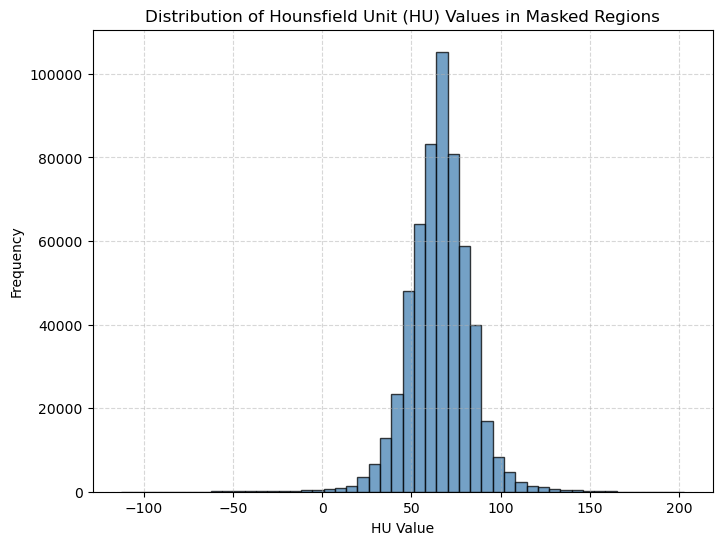

Mean HU: 65.78
Std Dev HU: 17.50
HU Value Range: [-113.00, 203.00]


In [70]:

def analyze_hounsfield_regions(images, masks):
    all_hu_values = []

    for img, msk in zip(images, masks):
        region_hu = img[msk == 1]
        all_hu_values.append(region_hu)

    all_hu_values = np.concatenate(all_hu_values)
    
    mean_hu = np.mean(all_hu_values)
    std_hu = np.std(all_hu_values)
    min_hu = np.min(all_hu_values)
    max_hu = np.max(all_hu_values)

    # Show histogram
    plt.figure(figsize=(8, 6))
    plt.hist(all_hu_values, bins=50, color='steelblue', edgecolor='black', alpha=0.75)
    plt.title("Distribution of Hounsfield Unit (HU) Values in Masked Regions")
    plt.xlabel("HU Value")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    print(f"Mean HU: {mean_hu:.2f}")
    print(f"Std Dev HU: {std_hu:.2f}")
    print(f"HU Value Range: [{min_hu:.2f}, {max_hu:.2f}]")

    return {
        "mean": mean_hu,
        "std": std_hu,
        "min": min_hu,
        "max": max_hu,
        "all_hu_values": all_hu_values
    }
#region = windowed_ct_images * liver_mask
results = analyze_hounsfield_regions(windowed_ct_images, liver_mask)

create code from a list of image and mask that has the same shape(slicesxheightxweight), obtain the region from the mask on the image, obtain the shape or somehting that can be circle shape, A segmentation algorithm has been implemented, and it uses either the centroid or the bounding box. the mask is a np array fof 1 and 0, and the normal image are float64
The segmentation algorithm works in volumetric 3D images, rather than on single slices. You can use hessian matrx, watershed, Canny, bank of filters, or gradient or a combination

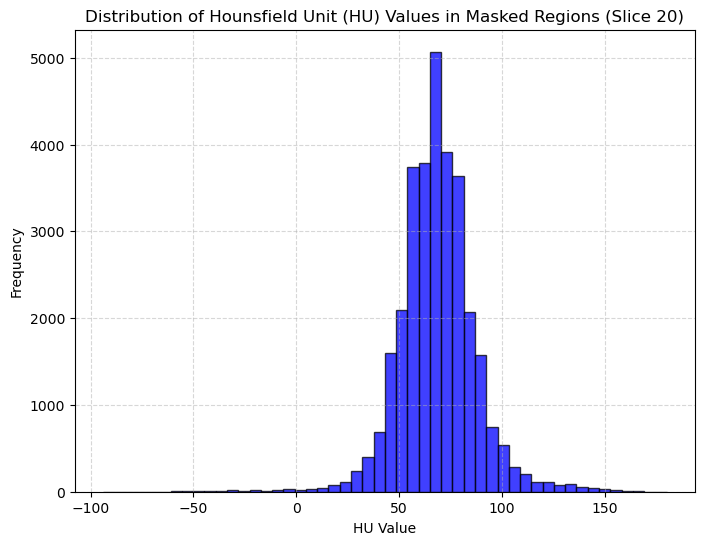

In the slice 20
Mean HU: 68.31
Std Dev HU: 18.77
HU Value Range min -94.00 and max 180.00


In [95]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def analyze_hounsfield_by_slice(image, mask):
    hounsfield_data = []
    for i in range(image.shape[0]):
        
        region_hu = image[i][mask[i] > 0]  # robust for bool or 0/1 mask

        # Handle case with no masked pixels in slice
        if region_hu.size == 0:
            mean_hu = std_hu = min_hu = max_hu = np.nan
        else:
            mean_hu = np.mean(region_hu)
            std_hu = np.std(region_hu)
            min_hu = np.min(region_hu)
            max_hu = np.max(region_hu)

        hounsfield_data.append({
            "slice_index": i,
            "mean": mean_hu,
            "std": std_hu,
            "min": min_hu,
            "max": max_hu,
            "hu_values": region_hu
        })
    return hounsfield_data

def show_plot(hounsfield_data, slice_idx):
    all_hu_values = hounsfield_data[slice_idx]['hu_values']
    data_slice=hounsfield_data[slice_idx]
    all_hu_values = np.ravel(all_hu_values)
    plt.figure(figsize=(8, 6))
    if all_hu_values.size > 0:
        plt.hist(all_hu_values, bins=50, color='blue', edgecolor='black', alpha=0.75)
    else:
        plt.text(0.5, 0.5, "No masked region in this slice.", ha="center", va="center")
    plt.title(f"Distribution of Hounsfield Unit (HU) Values in Masked Regions (Slice {slice_idx})")
    plt.xlabel("HU Value")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    print(f"In the slice {slice_idx}")
    print(f"Mean HU: {data_slice['mean']:.2f}")
    print(f"Std Dev HU: {data_slice['std']:.2f}")
    print(f"HU Value Range min {data_slice['min']:.2f} and max {data_slice['max']:.2f}")

hounsfield_data = analyze_hounsfield_by_slice(windowed_ct_images, liver_mask)
show_plot(hounsfield_data,20)

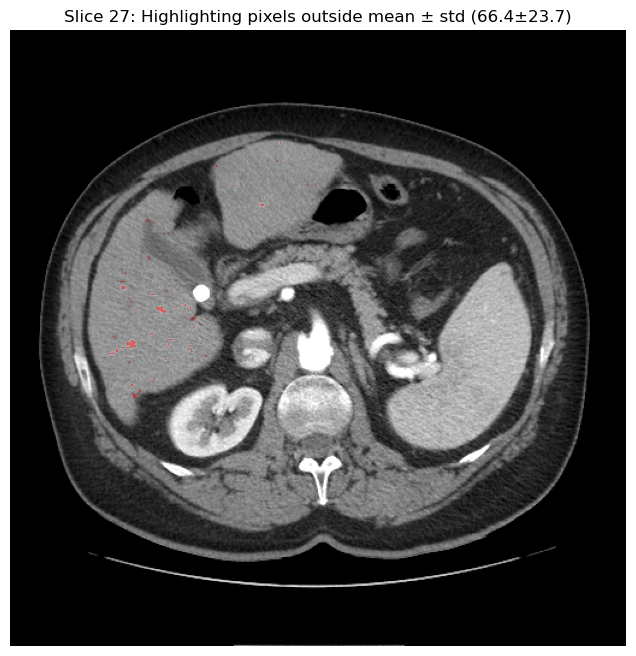

In [125]:
def highlight_hounsfield_std_outliers(image, mask, hounsfield_data, slice_idx):
    """
    Plots the slice, highlighting masked pixels that exceed mean ± std deviation.
    
    image: 3D numpy array (slices x height x width)
    mask: 3D numpy array (same shape), binary or boolean mask
    hounsfield_data: output from analyze_hounsfield_by_slice
    slice_idx: index of the slice to analyze/plot
    """
    slice_img = image[slice_idx]
    slice_mask = mask[slice_idx] > 0  # Ensure boolean mask
    
    mean_val = hounsfield_data[slice_idx]['mean']
    std_val = hounsfield_data[slice_idx]['std']
    std_val=std_val+8
    # Outlier mask: masked region AND outside mean ± std
    upper = mean_val + std_val
    lower = mean_val - std_val
    outlier_mask = np.zeros_like(slice_img, dtype=bool)
    outlier_mask[slice_mask] = (slice_img[slice_mask] >= upper) | (slice_img[slice_mask] <= lower)
    
    # Plot base slice
    plt.figure(figsize=(8, 8))
    plt.imshow(slice_img, cmap='gray')
    # Overlay: outliers in red, mask in yellow (optional)
    plt.imshow(np.ma.masked_where(~outlier_mask, outlier_mask), cmap='prism', alpha=0.5)
    # Optionally overlay the mask outline for context
    #plt.contour(slice_mask, colors='yellow', linewidths=1)
    plt.title(f"Slice {slice_idx}: Highlighting pixels outside mean ± std ({mean_val:.1f}±{std_val:.1f})")
    plt.axis('off')
    plt.show()

highlight_hounsfield_std_outliers(windowed_ct_images, liver_mask,hounsfield_data,27)

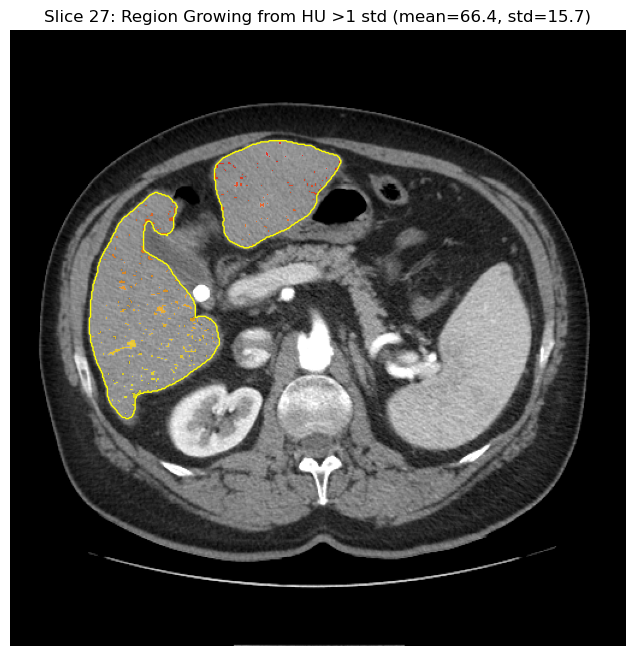

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label
from scipy.ndimage import binary_dilation

def region_growing_std_outliers(image, mask, hounsfield_data, slice_idx, connectivity=2, max_iters=100):

    slice_img = image[slice_idx]
    slice_mask = mask[slice_idx] > 0
    mean_val = hounsfield_data[slice_idx]['mean']
    std_val = hounsfield_data[slice_idx]['std']

    # Initial seeds: pixels in mask outside mean ± std
    upper = mean_val + std_val
    lower = mean_val - std_val
    seeds = np.zeros_like(slice_img, dtype=bool)
    seeds[slice_mask] = (slice_img[slice_mask] > upper) | (slice_img[slice_mask] < lower)

    # Region growing: iteratively dilate, but only grow into masked region and where value still exceeds ±std
    grown = seeds.copy()
    structure = np.ones((3, 3), dtype=bool) if connectivity == 2 else np.array([[0,1,0],[1,1,1],[0,1,0]], dtype=bool)

    for i in range(max_iters):
        # Dilate current region
        dilated = binary_dilation(grown, structure=structure)
        # Only allow in mask, and only if value still outside ± std
        candidates = dilated & slice_mask & ~grown
        new_pixels = (slice_img > upper) | (slice_img < lower)
        candidates = candidates & new_pixels
        # If no new pixels, stop
        if not np.any(candidates):
            break
        grown = grown | candidates

    # Optionally label connected regions (for display)
    labeled = label(grown, connectivity=connectivity)

    # Plot
    plt.figure(figsize=(8, 8))
    plt.imshow(slice_img, cmap='gray')
    plt.imshow(np.ma.masked_where(labeled == 0, labeled), cmap='autumn', alpha=0.7)
    plt.contour(slice_mask, colors='yellow', linewidths=1)
    plt.title(f"Slice {slice_idx}: Region Growing from HU >1 std (mean={mean_val:.1f}, std={std_val:.1f})")
    plt.axis('off')
    plt.show()

# Example usage (replace with your real data):
region_growing_std_outliers(windowed_ct_images, liver_mask, hounsfield_data, slice_idx=27)

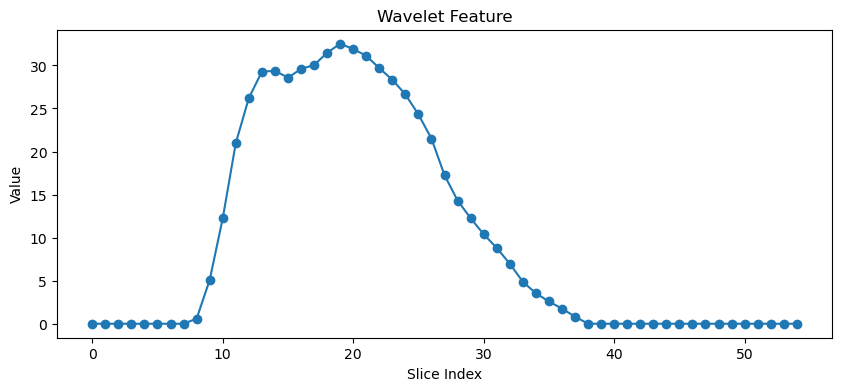

In [99]:
import numpy as np
import pywt
from skimage.filters import gabor
import matplotlib.pyplot as plt
import numpy as np
import pywt
from skimage.filters import gabor
import matplotlib.pyplot as plt

def texture_analysis_wavelet(image, mask, wavelet='db2', level=2):
    """
    Perform wavelet-based texture analysis, slice by slice.

    For each slice, mask out the region of interest, apply wavelet decomposition,
    and extract statistics (mean, std) from each sub-band.

    Returns:
        List of dicts with features per slice.
    """
    results = []
    for idx in range(image.shape[0]):
        slice_img = image[idx]
        slice_mask = mask[idx] > 0
        # Mask out non-ROI pixels (set to 0 or np.nan)
        masked_img = np.where(slice_mask, slice_img, 0)
        # Wavelet decomposition
        coeffs = pywt.wavedec2(masked_img, wavelet=wavelet, level=level)
        bands = {}
        # Approximation coefficients (cA)
        cA = coeffs[0]
        bands['cA_mean'] = np.mean(cA)
        bands['cA_std'] = np.std(cA)
        # Detail coefficients (cH, cV, cD) for each level
        for l, (cH, cV, cD) in enumerate(coeffs[1:], 1):
            bands[f'cH{l}_mean'] = np.mean(cH)
            bands[f'cH{l}_std'] = np.std(cH)
            bands[f'cV{l}_mean'] = np.mean(cV)
            bands[f'cV{l}_std'] = np.std(cV)
            bands[f'cD{l}_mean'] = np.mean(cD)
            bands[f'cD{l}_std'] = np.std(cD)
        results.append(bands)
    return results

def plot_wavelet_band_feature(wavelet_features, band='cA_mean', title='Wavelet Feature', ylabel='Value'):
    vals = [f[band] for f in wavelet_features]
    plt.figure(figsize=(10, 4))
    plt.plot(vals, marker='o')
    plt.title(title)
    plt.xlabel("Slice Index")
    plt.ylabel(ylabel)
    plt.show()
    # Wavelet analysis
wavelet_features = texture_analysis_wavelet(windowed_ct_images, liver_mask, wavelet='db2', level=2)
plot_wavelet_band_feature(wavelet_features)


In [ ]:
#valores que el higado contiene del hounsfield
#watershed como usa binarización no es tan sensible
# canny 4
# bank filters y gradient
# Hessian matrix

- Axial: Forma de cuña o semilunar, con el borde anterior afilado y el posterior más redondeado. Ocupa el cuadrante superior derecho, por debajo del diafragma y por encima del riñón derecho y la vesícula biliar. Suele ser el componente más grande y homogéneo en densidad en el abdomen superior.
- Coronal: Apariencia triangular o trapezoidal, con el vértice hacia el lado izquierdo. El borde superior sigue el contorno del diafragma y el inferior es más irregular, adaptándose a las vísceras abdominales. El lóbulo derecho es más grande y el izquierdo se extiende hacia la línea media.
- Sagital: Perfil convexo superior (bajo el diafragma) y cóncavo inferior (por la impresión del colon y otras vísceras). Puede verse una masa homogénea grande en la parte anterior del abdomen, por encima del riñón derecho.

**Visualize both the provided Tumor mask and the segmented Tumor mask on the image.
Assess the correctness of the algorithm, numerically and visually**

This dataset appears to represent a CT Image Storage object, as indicated by the SOP Class UID (CT Image Storage) and other attributes related to CT imaging. To extract the Referenced Segment Number, you would need a DICOM Segmentation object that contains labeled segments and their corresponding metadata.